In [46]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import math
import glob
import os
import cv2


## 이미지 전처리

In [47]:
# 이미지 불러오기 및 이미지 사이즈 재설정
def read_img(path):
    original_img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    resized_img = cv2.resize(original_img, (800, 1000))
    
    return resized_img


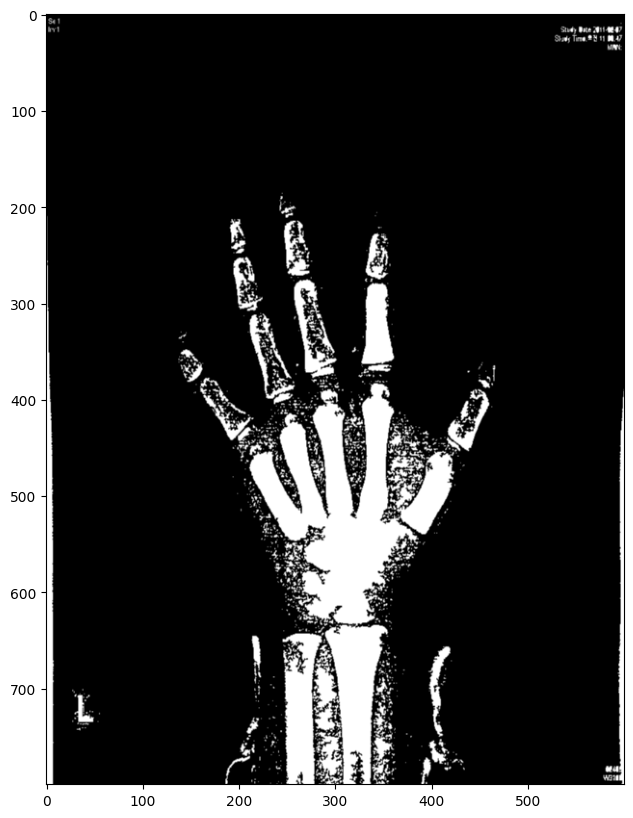

In [53]:
# 이미지 밝기 조절, 대비, 필터링 작업
def Decomposing(resized_img,a,b,d,e):

    ######## Decomposing_stage_1 / [ Contours , Mask ] ########
    decomp_img_1 = resized_img.copy()

    ## Adjusting brighness
    d_img1 = decomp_img_1.copy()
    cols, rows = d_img1.shape[:2]
    brightness1 = np.sum(d_img1) / (255 * cols * rows)

    if brightness1 > 0.8:
        decomp_img_1 = np.clip(decomp_img_1 - 80., 0, 255).astype(np.uint8)
    elif brightness1 > 0.75:
        decomp_img_1 = np.clip(decomp_img_1 - 50., 0, 255).astype(np.uint8)
    elif brightness1 > 0.65:
        decomp_img_1 = np.clip(decomp_img_1 - 30., 0, 255).astype(np.uint8)
    else: decomp_img_1 = np.clip(decomp_img_1 - 10., 0, 255).astype(np.uint8)


    ## change to Lab
    decomp_img_1 = cv2.cvtColor(decomp_img_1, cv2.COLOR_RGB2BGR)
    decomp_img_1 = cv2.cvtColor(decomp_img_1, cv2.COLOR_BGR2Lab)

    ## Morphology
    k = cv2.getStructuringElement(cv2.MORPH_CROSS, (a, a))
    decomp_img_1 = cv2.morphologyEx(decomp_img_1, cv2.MORPH_TOPHAT, k) # Emphasis

    ## Filter
    decomp_img_1 = cv2.bilateralFilter(decomp_img_1,-1, d, e)

    ## Lab to gray for binary
    decomp_img_1 = cv2.cvtColor(decomp_img_1, cv2.COLOR_Lab2BGR)
    decomp_img_1 = cv2.cvtColor(decomp_img_1, cv2.COLOR_BGR2GRAY)

    ## img_normalization
    decomp_img_1 = cv2.normalize(decomp_img_1, None, 0, 255, cv2.NORM_MINMAX)

    ## CLAHE
    decomp_img_1 = cv2.equalizeHist(decomp_img_1)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(10, 10)) 
    decomp_img_1= clahe.apply(decomp_img_1)          


    ## Threshold / value = img.mean()
    ret, mask = cv2.threshold(decomp_img_1,
                            122,
                            255,
                            cv2.THRESH_BINARY) 

    ## Extract object / same value pixels

    contours, hierarchy = cv2.findContours(mask, 
                                            cv2.RETR_EXTERNAL, # only outline
                                            cv2.CHAIN_APPROX_SIMPLE) # Contour vertex coordinate

    ## drawing Contours
    cv2.drawContours(mask, contours, -1, (255,255,255), -1) # -1: 모든 컨트어 표시 /color/ fill


        
    ######## Decomposing_stage_2 / [ Brightness_Empahsis ] ########
    decomp_img_2 = resized_img.copy()

    ## Brightness_Empahsis
    d_img2 = decomp_img_2.copy()
    cols, rows = d_img2.shape[:2]
    brightness2 = np.sum(d_img2) / (255 * cols * rows)

    ## Empahsis
    if brightness2 > 0.8:
        decomp_img_2 = np.clip(decomp_img_2 - 80., 0, 255).astype(np.uint8)
    elif brightness2 > 0.75:
        decomp_img_2 = np.clip(decomp_img_2 - 50., 0, 255).astype(np.uint8)
    elif brightness2 > 0.65:
        decomp_img_2 = np.clip(decomp_img_2 - 30., 0, 255).astype(np.uint8)
    else: decomp_img_2 = np.clip(decomp_img_2 - 10., 0, 255).astype(np.uint8)


    ## Morphology
    k2 = cv2.getStructuringElement(cv2.MORPH_CROSS,(b,b))
    decomp_img_2 = cv2.morphologyEx(decomp_img_2, cv2.MORPH_TOPHAT, k2)

    ## contrast
    decomp_img_2 = cv2.cvtColor(decomp_img_2, cv2.COLOR_BGR2RGB)
    decomp_img_2 = cv2.cvtColor(decomp_img_2, cv2.COLOR_BGR2GRAY)

    if decomp_img_2.mean() <= 15:
        low = decomp_img_2.mean() * 3.2
        high = decomp_img_2.mean() * 3.6
    elif decomp_img_2.mean() <= 20:
        low = decomp_img_2.mean() * 3
        high = decomp_img_2.mean() * 3.6
    else:
        low = decomp_img_2.mean() * 3
        high = decomp_img_2.mean() * 3.7

    decomp_img_2 = cv2.blur(decomp_img_2,(2,2))
    h, w = decomp_img_2.shape
    img_ = np.zeros(decomp_img_2.shape, dtype=np.uint8)

    for y in range(h):
        for x in range(w):
            temp = int((255 / (high - low)) * (decomp_img_2[y][x] - low))
            if temp > 255:
                img_[y][x] = 255
            elif temp < 0:
                img_[y][x] = 0
            else:
                img_[y][x] = temp

    decomp_img_2 = img_.copy()


    ######## Decomposing_Final_stage / [ Result ] ########
    ### Bone empahsis / bitwise (mask)
    ## Morphology
    ## Contours
    contours, hierarchy = cv2.findContours(decomp_img_2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(decomp_img_2, contours, -1, (255, 255, 255), -1)

    ## Bitwise (mask) / print white parts

    decomp_img_2 = cv2.bitwise_and(decomp_img_2, mask) 

    decomp_img_2 = cv2.cvtColor(decomp_img_2, cv2.COLOR_GRAY2BGR)
    decomp_img_2 = cv2.blur(decomp_img_2,(2,2))

    bone_extraction = cv2.resize(decomp_img_2, (600, 800))

    return bone_extraction


# 테스트를 위한 이미지 경로
image_path = '../BoneAge/Data/filtering_img/6_M.jpg'

# 이미지 불러오기
image = cv2.imread(image_path)

# 이미지 이진화
bone_extraction = Decomposing(image, 20, 20, 60, 70)  #60, 55, 50, 25

# 결과 이미지 출력
plt.figure(figsize=(15,10))
plt.imshow(bone_extraction, "gray")
plt.show()

In [41]:
def preprocess(path):
    try:
        resized_img = read_img(path)
        bone_extraction = Decomposing(resized_img, 60, 55, 50, 25)

        return bone_extraction
    
    except:
        print('ERROR > Please check again' )

## 전체 이미지에 대해서 실행

In [42]:
# 이미지 경로
path = '../BoneAge/Data/image/'
original_img_path = glob.glob(path + "*.jpg")
processed_img_path = '../BoneAge/Data/preprocess_image/'

In [43]:
for i in original_img_path:
    preprocess_img = preprocess(i)

    file_name = os.path.basename(i)
    save_path = os.path.join(processed_img_path, file_name)

    cv2.imwrite(save_path, preprocess_img)